In [406]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [407]:
from utils.analysis_helpers import *
from bertopic import BERTopic

# Define the Docs

In [408]:
df_all = pd.read_csv("segmented_sentences.csv")
# Rename Segmented_Sentence to Content
df_all = df_all.rename(columns={"Segmented_Sentence": "Content"})
df_all

,File Name,turn_index,Speaker,Experiment,Id,Condition,Full_Content,Content
0,ID 05,0,Interviewer,OBE1,5,1,"No, don't worry, it's just...","no, don't worry, it's just..."
1,ID 05,1,Participant,OBE1,5,1,"So, that was very, let's say, unexpected and s...","so, that was very, let's say, unexpected and s..."
2,ID 05,1,Participant,OBE1,5,1,"So, that was very, let's say, unexpected and s...","i mean, at least that's what i felt, that i wa..."
3,ID 05,1,Participant,OBE1,5,1,"So, that was very, let's say, unexpected and s...",and then i was observing it from above
4,ID 05,1,Participant,OBE1,5,1,"So, that was very, let's say, unexpected and s...","and as i was saying, i felt at a specific mome..."
...,...,...,...,...,...,...,...,...
2914,S313,39,Participant,Compassion,313,1,I know that's true. When I felt like sending l...,i know that's true when i felt like sending lo...
2915,S313,39,Participant,Compassion,313,1,I know that's true. When I felt like sending l...,i sent them to the person so maybe in both pla...
2916,S313,39,Participant,Compassion,313,1,I know that's true. When I felt like sending l...,"i didn't feel it was me, but i felt it was mys..."
2917,S313,40,Interviewer,Compassion,313,1,"Okay, I see. The answers for my questions.",okay


In [626]:
# Preoprocessing
df = df_all.copy()
# Focus only on the participant's or interviewer's speech or both
df = df[df["Speaker"] == "Participant"]
#df = df[df["Speaker"] == "Interviewer"]

# Select experiment
df = df[df["Experiment"] != "Compassion"]

# Filter tokens (stopwords, punctuations) were removed using the spacy library, 
# All text was lowercased + lemmatized,
# Plus extra_stopwords being the most frequents words in the corpus AND being meaningless 
extra_stopwords = [
    # Filler Words: Common conversational placeholders without thematic value
    "yeah", "okay", "yes", "mean", "oh", "ah", "like", "kind","kinda", "course", "way",
    # Vague/Ambiguous Words: Frequent but thematically irrelevant in conversations
    "think", "know", "really", "bit", "feel", "thing", "sort", "maybe", "little", "actually",
    "sure", "exactly", "tell", "ask", "people", "think",
    # Broad terms or context-specific words overshadowing subtler themes
    "question", "sorry", "time", "first", "second", "later", "experience", "end", "meditation"
]
df['preprocessed_content'] = df['Content'].apply(lambda x: preprocess_text(x, extra_stopwords=extra_stopwords, retain_stopwords=["yourself", "myself"]))

# Remove rows with empty content or content that's only punctuation after preprocessing
df = df[df['preprocessed_content'].str.strip().str.len() > 0]
# File S225 is removed because it is empty after preprocessing (only two utterances, not meaningful words for topics)
 # -> it was the Intervention condition, so mostly only discuss the sencond condition (control)

df.to_csv("preprocessed_content.csv", index=False)

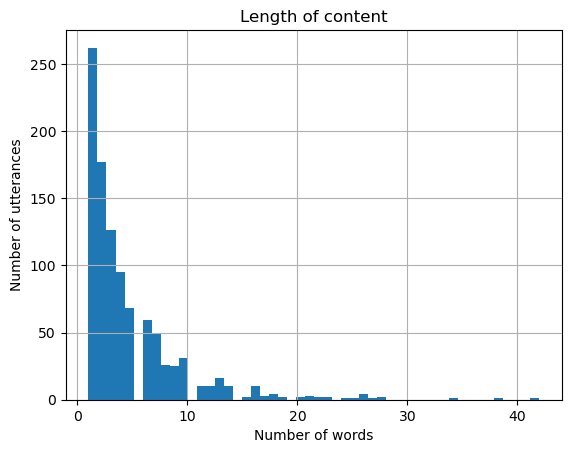

In [627]:
# See the length of the preprocessed content
df['preprocessed_content'].apply(lambda x: len(x.split())).hist(bins=50)
plt.title("Length of content")
plt.xlabel("Number of words")
plt.ylabel("Number of utterances")
plt.show()

In [628]:
df = df.groupby(['File Name','turn_index']).agg({ 
    'Content': ' '.join,  # Combine raw text
    'preprocessed_content': ' '.join,  # Combine preprocessed text
    'Experiment': 'first',   # Keep the first 
    'Condition': 'first',   # Keep the first
    'Id': 'first',   # Keep the first
    'Speaker': 'first',   # Keep the first
}).reset_index()
df

,File Name,turn_index,Content,preprocessed_content,Experiment,Condition,Id,Speaker
0,ID 05,1,"so, that was very, let's say, unexpected and s...",let unexpected surprising moment go realize ge...,OBE1,1,5,Participant
1,ID 05,3,"a little bit it was a little bit like, okay, w...",watch outside special give lot emotion explain...,OBE1,1,5,Participant
2,ID 05,5,yeah yeah i feel like i'm back it's okay but y...,get perfect description,OBE1,1,5,Participant
3,ID 05,7,"the thing that i didn't really understand, but...",understand understand body touching basically ...,OBE1,1,5,Participant
4,ID 05,9,so i felt like a time lag in the last one of w...,lag see body,OBE1,1,5,Participant
...,...,...,...,...,...,...,...,...
576,S230 intervention,35,i don't know unpleasant i probably say i'm no...,unpleasant probably pleasant unpleasant cool i...,OBE2,I,230,Participant
577,S230 intervention,37,to be honest when i was out of my body i was m...,honest body concentrate happen moment meditate...,OBE2,I,230,Participant
578,S230 intervention,39,"probably yeah, i think i was less concentrate ...",probably concentrate body concentrate look din...,OBE2,I,230,Participant
579,S230 intervention,41,i don't think so what was the question about l...,have body,OBE2,I,230,Participant


In [629]:
docs = list(df.preprocessed_content)
print(len(docs))

581


In [630]:
# look rows with a specific word in the column preprocessed_content
#df[df['preprocessed_content'].str.contains("course")]

# Define the model

In [631]:
from sentence_transformers import SentenceTransformer

# Pre-calculate embeddings
embedding_model = SentenceTransformer("all-mpnet-base-v2") # Better but slower: all-mpnet-base-v2 || Trade-off: all-MiniLM-L6-v2
embeddings = embedding_model.encode(docs, show_progress_bar=True)

Batches: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]


In [632]:
from umap import UMAP
from hdbscan import HDBSCAN

# Dimensionality reduction model
umap_model = UMAP(n_neighbors=15, n_components=8, min_dist=0.0, metric='cosine', random_state=42)

# Clustering model
hdbscan_model = HDBSCAN(min_cluster_size=11, metric='euclidean', cluster_selection_method='eom')

topic_model = BERTopic(                     
# Pipeline models
embedding_model=embedding_model,
umap_model=umap_model,
hdbscan_model=hdbscan_model,
# Hyperparameters
verbose=True)

In [633]:
topics, ini_probs = topic_model.fit_transform(docs)
num_topics = len(topic_model.get_topics()) - 1
num_topics

2025-01-06 23:40:56,897 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 19/19 [00:09<00:00,  1.93it/s]
2025-01-06 23:41:06,782 - BERTopic - Embedding - Completed ✓
2025-01-06 23:41:06,783 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-01-06 23:41:08,147 - BERTopic - Dimensionality - Completed ✓
2025-01-06 23:41:08,148 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-01-06 23:41:08,164 - BERTopic - Cluster - Completed ✓
2025-01-06 23:41:08,167 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-01-06 23:41:08,193 - BERTopic - Representation - Completed ✓


10

In [634]:
topic_model.get_topic_info().to_csv("topic_model.csv")
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,117,-1_happen_interesting_move_notice,"[happen, interesting, move, notice, realize, m...",[different disconnected surround happen surrou...
1,0,221,0_body_myself_touch_focus,"[body, myself, touch, focus, see, look, feelin...",[see body mirror have body see see myself outs...
2,1,46,1_relax_sleep_asleep_calm,"[relax, sleep, asleep, calm, fall, relaxed, re...","[fall asleep, calm want sleep, relaxed afraid ..."
3,2,39,2_body_light_heavy_outside,"[body, light, heavy, outside, see, come, insid...","[body, body, body]"
4,3,31,3_want_follow_guy_minute,"[want, follow, guy, minute, see, go, love, res...","[want, see guy, right guy want break]"
5,4,30,4_nice_fine_absolutely_good,"[nice, fine, absolutely, good, fun, pretty, de...","[nice, fun nice, absolutely fine]"
6,5,28,5_forest_tree_rock_setting,"[forest, tree, rock, setting, element, nice, a...",[realize need follow instruction stop stop par...
7,6,24,6_color_pixel_image_change,"[color, pixel, image, change, see, yellow, qua...",[see difference color head signal send rest se...
8,7,18,7_different_difference_normal_hard,"[different, difference, normal, hard, life, ma...","[view different hard main difference go fast, ..."
9,8,14,8_avatar_blink_sync_link,"[avatar, blink, sync, link, notice, synchroniz...","[refer avatar avatar myself, avatar blink avat..."


In [635]:
# # Reduce outliers with pre-calculate embeddings
# new_topics = topic_model.reduce_outliers(docs, topics, strategy="embeddings", embeddings=embeddings)
# topic_model.update_topics(docs, topics=new_topics)
# topics = new_topics

# # Display new topics
# topic_model.get_topic_info()

In [636]:
topic_model.visualize_barchart(top_n_topics=16)

In [637]:
topic_model.visualize_topics()

In [638]:
#topic_model.visualize_heatmap(n_clusters = num_topics-1)

In [639]:
#topics_per_class = topic_model.topics_per_class(docs, classes=df.Id)
#topic_model.visualize_topics_per_class(topics_per_class)

In [640]:
#topics_per_class

In [641]:
#hierarchical_topics = topic_model.hierarchical_topics(docs)
#topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [642]:
df['one_topic'] = topics
topic_name_to_id = dict(zip(topic_model.get_topic_info().Topic, topic_model.get_topic_info().Name))
df['one_topic_name'] = df['one_topic'].map(topic_name_to_id)

df.to_csv("df_topic.csv", index = False)

In [643]:
topic_name_to_id

{-1: '-1_happen_interesting_move_notice',
 0: '0_body_myself_touch_focus',
 1: '1_relax_sleep_asleep_calm',
 2: '2_body_light_heavy_outside',
 3: '3_want_follow_guy_minute',
 4: '4_nice_fine_absolutely_good',
 5: '5_forest_tree_rock_setting',
 6: '6_color_pixel_image_change',
 7: '7_different_difference_normal_hard',
 8: '8_avatar_blink_sync_link',
 9: '9_strange_funny_weird_accept'}

# Topic Distribution (More than one topic per docs) 
- To reduce the numbers of outliers and avoid False Positive (Interesting when looking at one specif topic)

### Look similarities

In [644]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np 

distance_matrix = cosine_similarity(np.array(topic_model.topic_embeddings_))
dist_df = pd.DataFrame(distance_matrix, columns=topic_model.topic_labels_.values(), 
                       index=topic_model.topic_labels_.values())

tmp = []
for rec in dist_df.reset_index().to_dict('records'):
    t1 = rec['index']
    for t2 in rec:
        if t2 == 'index': 
            continue
        tmp.append(
            {
                'topic1': t1, 
                'topic2': t2, 
                'distance': rec[t2]
            }
        )

pair_dist_df = pd.DataFrame(tmp)

pair_dist_df = pair_dist_df[(pair_dist_df.topic1.map(
      lambda x: not x.startswith('-1'))) & 
            (pair_dist_df.topic2.map(lambda x: not x.startswith('-1')))]
pair_dist_df = pair_dist_df[pair_dist_df.topic1 < pair_dist_df.topic2]
pair_dist_df.sort_values('distance', ascending = False).head(20)

,topic1,topic2,distance
49,3_want_follow_guy_minute,4_nice_fine_absolutely_good,0.639760
14,0_body_myself_touch_focus,2_body_light_heavy_outside,0.609379
20,0_body_myself_touch_focus,8_avatar_blink_sync_link,0.574854
18,0_body_myself_touch_focus,6_color_pixel_image_change,0.572367
26,1_relax_sleep_asleep_calm,3_want_follow_guy_minute,0.550662
27,1_relax_sleep_asleep_calm,4_nice_fine_absolutely_good,0.540396
13,0_body_myself_touch_focus,1_relax_sleep_asleep_calm,0.532961
52,3_want_follow_guy_minute,7_different_difference_normal_hard,0.524671
54,3_want_follow_guy_minute,9_strange_funny_weird_accept,0.505017
98,7_different_difference_normal_hard,9_strange_funny_weird_accept,0.499553


### Multiples topics

In [645]:
topic_distr, topic_token_distr = topic_model.approximate_distribution(
      docs, window = 5, calculate_tokens=True)

100%|██████████| 1/1 [00:00<00:00, 19.39it/s]


In [646]:
import tqdm
import plotly.express as px

tmp_dfs = []

# iterating through different threshold levels
for thr in tqdm.tqdm(np.arange(0, 0.35, 0.001)):
    # calculating number of topics with probability > threshold for each document
    tmp_df = pd.DataFrame(list(map(lambda x: len(list(filter(lambda y: y >= thr, x))), topic_distr))).rename(
        columns = {0: 'num_topics'}
    )
    tmp_df['num_docs'] = 1
    
    tmp_df['num_topics_group'] = tmp_df['num_topics']\
        .map(lambda x: str(x) if x < 5 else '5+')
    
    # aggregating stats
    tmp_df_aggr = tmp_df.groupby('num_topics_group', as_index = False).num_docs.sum()
    tmp_df_aggr['threshold'] = thr
    
    tmp_dfs.append(tmp_df_aggr)

num_topics_stats_df = pd.concat(tmp_dfs).pivot(index = 'threshold', 
                              values = 'num_docs',
                              columns = 'num_topics_group').fillna(0)

num_topics_stats_df = num_topics_stats_df.apply(lambda x: 100.*x/num_topics_stats_df.sum(axis = 1))

# visualisation
colormap = px.colors.sequential.YlGnBu
px.area(num_topics_stats_df, 
       title = 'Distribution of number of topics',
       labels = {'num_topics_group': 'number of topics',
                'value': 'share of reviews, %'},
       color_discrete_map = {
          '0': colormap[0],
          '1': colormap[3],
          '2': colormap[4],
          '3': colormap[5],
          '4': colormap[6],
          '5+': colormap[7]
      })

100%|██████████| 350/350 [00:01<00:00, 248.11it/s]


In [647]:
threshold = 0.2

# define topic with probability > 0.13 for each document
df['multiple_topics'] = list(map(
    lambda doc_topic_distr: list(map(
        lambda y: y[0], filter(lambda x: x[1] >= threshold, 
                               (enumerate(doc_topic_distr)))
    )), topic_distr
))

# creating a dataset with docid, topic
tmp_data = []

for rec in df.to_dict('records'):
    if len(rec['multiple_topics']) != 0:
        mult_topics = rec['multiple_topics']
    else:
        mult_topics = [-1]
        
    for topic in mult_topics: 
        tmp_data.append(
            {
                'topic': topic,
                'id': rec['Content'],
            }
        )
            
mult_topics_df = pd.DataFrame(tmp_data)
df["multiple_topics_name"] = df["multiple_topics"].map(lambda x: [topic_name_to_id.get(i, "No topic") for i in x])


In [648]:
df.to_csv("df_topic.csv", index = False)
df.head()

,File Name,turn_index,Content,preprocessed_content,Experiment,Condition,Id,Speaker,one_topic,one_topic_name,multiple_topics,multiple_topics_name
0,ID 05,1,"so, that was very, let's say, unexpected and s...",let unexpected surprising moment go realize ge...,OBE1,1,5,Participant,0,0_body_myself_touch_focus,[0],[0_body_myself_touch_focus]
1,ID 05,3,"a little bit it was a little bit like, okay, w...",watch outside special give lot emotion explain...,OBE1,1,5,Participant,0,0_body_myself_touch_focus,[0],[0_body_myself_touch_focus]
2,ID 05,5,yeah yeah i feel like i'm back it's okay but y...,get perfect description,OBE1,1,5,Participant,0,0_body_myself_touch_focus,[],[]
3,ID 05,7,"the thing that i didn't really understand, but...",understand understand body touching basically ...,OBE1,1,5,Participant,0,0_body_myself_touch_focus,[0],[0_body_myself_touch_focus]
4,ID 05,9,so i felt like a time lag in the last one of w...,lag see body,OBE1,1,5,Participant,2,2_body_light_heavy_outside,"[0, 2]","[0_body_myself_touch_focus, 2_body_light_heavy..."


### Look differences btw single and multiple topics

In [649]:
topic_name_to_id

{-1: '-1_happen_interesting_move_notice',
 0: '0_body_myself_touch_focus',
 1: '1_relax_sleep_asleep_calm',
 2: '2_body_light_heavy_outside',
 3: '3_want_follow_guy_minute',
 4: '4_nice_fine_absolutely_good',
 5: '5_forest_tree_rock_setting',
 6: '6_color_pixel_image_change',
 7: '7_different_difference_normal_hard',
 8: '8_avatar_blink_sync_link',
 9: '9_strange_funny_weird_accept'}

In [650]:
# look for a specific topic the topic 12
specific_topic = df[df['one_topic'] == 12]
print(len(specific_topic))
# look at specifc columns
specific_topic[['Experiment','Id','Condition','Speaker','Content','multiple_topics_name']]

0


,Experiment,Id,Condition,Speaker,Content,multiple_topics_name


In [651]:
# look for a specific topic the topic 12
specific_topic = df[df['multiple_topics'].map(lambda x: 12 in x)]
print(len(specific_topic))
# look at specifc columns
specific_topic[['Experiment','Id','Condition','Speaker','Content','multiple_topics_name']]

0


,Experiment,Id,Condition,Speaker,Content,multiple_topics_name
